In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

sms = pd.read_csv("preprocessed_sms.csv", encoding='latin-1')

sms['label'] = sms['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(sms['message'], sms['label'], test_size=0.3, random_state=42)

In [17]:
# Токенізація тексту за допомогою BERT Tokenizer
from transformers import BertTokenizer

# Завантаження токенайзера BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Токенізація тексту
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [21]:
import tensorflow as tf

# Створення тензорів для міток
train_labels = tf.convert_to_tensor(y_train.values)
test_labels = tf.convert_to_tensor(y_test.values)

# Створення TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(X_train)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

In [22]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# Завантаження моделі BERT для класифікації
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Налаштування оптимізатора
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5)

# Визначення функції втрат
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Компіляція моделі
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Навчання моделі
history = model.fit(train_dataset, epochs=3)

Epoch 1/3
244/244 [==============================] - 840s 3s/step - loss: 0.0807 - accuracy: 0.9756
Epoch 2/3
244/244 [==============================] - 767s 3s/step - loss: 0.0156 - accuracy: 0.9949
Epoch 3/3
244/244 [==============================] - 782s 3s/step - loss: 0.0202 - accuracy: 0.9941


In [56]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_filename = f'bert_sms_classifier_{timestamp}'

model.save(f'./models/{model_filename}')

INFO:tensorflow:Assets written to: ./models/bert_sms_classifier_20240613-015603/assets


INFO:tensorflow:Assets written to: ./models/bert_sms_classifier_20240613-015603/assets


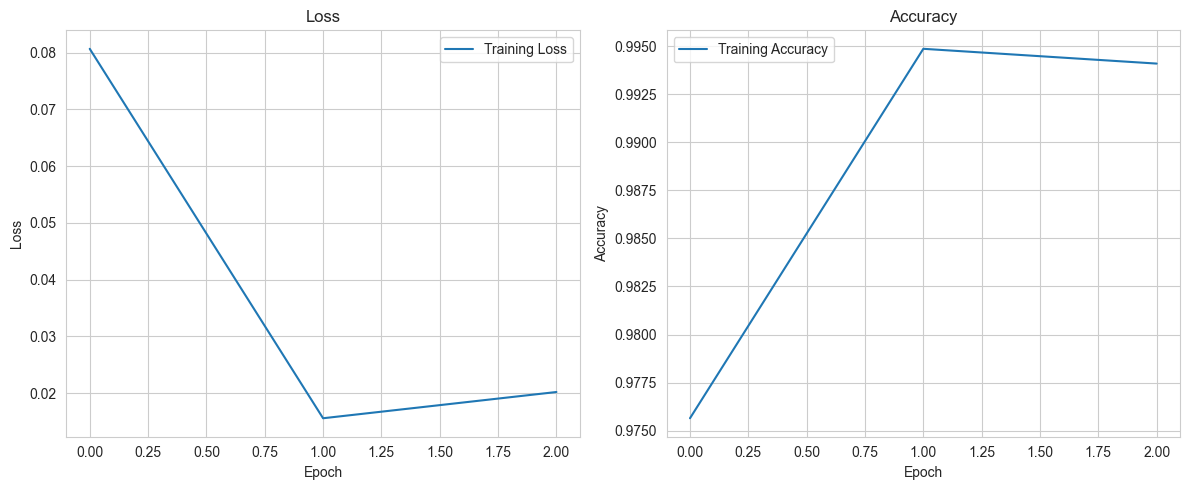

In [46]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [49]:
loaded_model = tf.keras.models.load_model(f'./models/{model_filename}')

In [50]:
from sklearn.metrics import accuracy_score

# Прогнозування на тестових даних
predictions = loaded_model.predict(test_dataset)

105/105 [==============================] - 98s 923ms/step


In [51]:
pred_labels = tf.argmax(predictions['logits'], axis=1).numpy()

accuracy = accuracy_score(y_test, pred_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9946172248803827


In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_labels, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1453
        spam       0.99      0.97      0.98       219

    accuracy                           0.99      1672
   macro avg       0.99      0.98      0.99      1672
weighted avg       0.99      0.99      0.99      1672



2024-06-13 01:06:36.992776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


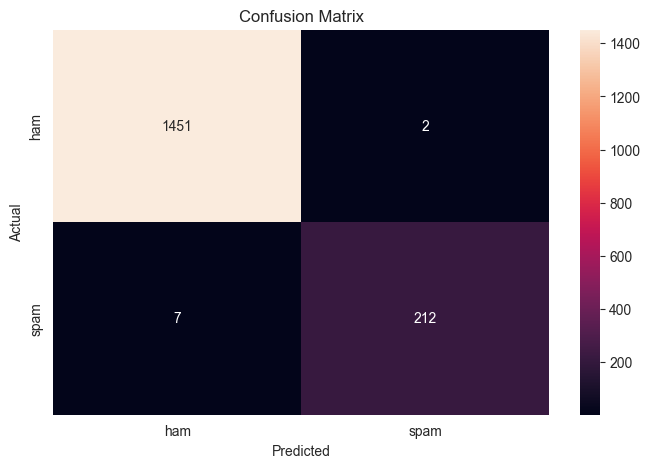

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_pred = tf.argmax(predictions['logits'], axis=1).numpy()
y_true = np.concatenate([batch[1].numpy() for batch in test_dataset]) 

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [33]:
import gradio as gr

def classify_message(message):
    inputs = tokenizer(message, return_tensors="tf", truncation=True, padding=True, max_length=128)
    test_predictions = loaded_model(inputs)
    test_logits = test_predictions['logits']
    probabilities = tf.nn.softmax(test_logits, axis=1).numpy()
    return {'Ham': probabilities[0][0],
            'Spam': probabilities[0][1]}

interface = gr.Interface(
    fn=classify_message,
    inputs=gr.Textbox(lines=2, placeholder="Enter SMS message..."),
    outputs=gr.Textbox(),
    title="SMS Ham/Spam Classifier",
    description="Enter an SMS message to classify it as Ham or Spam."
)

interface.launch(debug=True, inbrowser=True)

Running on local URL:  http://127.0.0.1:7860

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
